### Project description
The AIDS Clinical Trials Group Study 175 Dataset contains healthcare statistics and categorical information about patients who have been diagnosed with AIDS. This dataset was initially published in 1996. The prediction task is to predict whether or not each patient died within a certain window of time or not.

Column description:
* time - time to failure or censoring
* trt - treatment indicator, medication used for treatment (0 = ZDV only; 1 = ZDV + ddI, 2 = ZDV + Zal, 3 = ddI only). Where ZDV stands for Zidovudine, ddi stands for Drug-drug interactions and Zal stands for Zalcitabine.
* wtkg - weight in kg
* hemo - hemophilia (0=no, 1=yes)
* homo - homosexual activity (0=no, 1=yes)
* drugs - history of Intervanous drug use (0=no, 1=yes)
* karnof - Karnofsky score (on a scale of 0-100) where 0 means dead, 100 means no evidence of disease
* oprior - Non-ZDV antiretroviral therapy pre-175 (AIDS Clinical Trials Group Study 175) -> (0=no, 1=yes)
* z30 - ZDV in the 30 days prior to 175 (0=no, 1=yes)
* zprior - ZDV prior to 175 (0=no, 1=yes)
* preanti - days pre-175 anti-retroviral therapy
* race - race (0=White, 1=non-white)
* gender - gender (0=F, 1=M)
* str2 - antiretroviral history (0=naive, 1=experienced)
* strat - antiretroviral history stratification (1='Antiretroviral Naive',2='> 1 but <= 52 weeks of prior antiretroviral therapy',3='> 52 weeks)
* symptom - symptomatic indicator (0=asymp, 1=symp)
* trat - treatment indicator (0=ZDV only, 1=others)
* offtrt - 	indicator of off-trt before 96+/-5 weeks (0=no,1=yes)
* cd40 - CD4 (Clusters of differentiation 4 are glycoproteins present on the immune cells' surface such as monocytes) at baseline
* cd80 - CD8 (cells called cytotoxic T-lymphocytes) at baseline
* cd420 - CD4 at 20+/-5 weeks
* cd820 - CD8 at 20+/-5 weeks
* pidnum - Patient ID
* cid - censoring indicator (1 = failure, 0 = censoring), Death or Censored (did not die within the time of observation)



**- Personal information (age, weight, race, gender, sexual activity)**

**- Medical history (hemophilia, history of IV drugs)**

**- Treatment history (ZDV/non-ZDV treatment history)**

**- Lab results (CD4/CD8 counts)**



In [52]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#Dataset load library
from ucimlrepo import fetch_ucirepo

#Preprocessing and hyperparameter tuning
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif
from sklearn.model_selection import cross_validate,cross_val_score,GridSearchCV,KFold,ParameterGrid,train_test_split,StratifiedKFold
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, classification_report,confusion_matrix

# Imbalanced data
from imblearn.over_sampling import SMOTE

np.random.seed(42)


## Load Dataset

In [2]:
# Read Dataset - AIDS Clinical Trials Group Study 175
aids_clinical_trials_group_study_175 = fetch_ucirepo(id=890)

# data (as pandas dataframes)
X = aids_clinical_trials_group_study_175.data.features
y = aids_clinical_trials_group_study_175.data.targets

## Data Analysis

In [3]:
# First 5 rows of X - independent variables
X.head()

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,gender,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,0,1,0,1,0,422,477,566,324
1,1002,3,61,49.4424,0,0,0,90,0,1,...,0,1,3,0,1,0,162,218,392,564
2,961,3,45,88.4520,0,1,1,90,0,1,...,1,1,3,0,1,1,326,274,2063,1893
3,1166,3,47,85.2768,0,1,0,100,0,1,...,1,1,3,0,1,0,287,394,1590,966
4,1090,0,43,66.6792,0,1,0,100,0,1,...,1,1,3,0,0,0,504,353,870,782


In [4]:
# First 5 rows of y - dependent variable(target)
y.head()

,cid
0,0
1,1
2,0
3,0
4,0


In [8]:
# This code here, give us info about every feature datatype and how much non-null features we have
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 23 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time     2139 non-null   int64  
 1   trt      2139 non-null   int64  
 2   age      2139 non-null   int64  
 3   wtkg     2139 non-null   float64
 4   hemo     2139 non-null   int64  
 5   homo     2139 non-null   int64  
 6   drugs    2139 non-null   int64  
 7   karnof   2139 non-null   int64  
 8   oprior   2139 non-null   int64  
 9   z30      2139 non-null   int64  
 10  zprior   2139 non-null   int64  
 11  preanti  2139 non-null   int64  
 12  race     2139 non-null   int64  
 13  gender   2139 non-null   int64  
 14  str2     2139 non-null   int64  
 15  strat    2139 non-null   int64  
 16  symptom  2139 non-null   int64  
 17  treat    2139 non-null   int64  
 18  offtrt   2139 non-null   int64  
 19  cd40     2139 non-null   int64  
 20  cd420    2139 non-null   int64  
 21  cd80     2139 

In [9]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   cid     2139 non-null   int64
dtypes: int64(1)
memory usage: 16.8 KB


In [10]:
# Shape of X,y (number of rows,number of columns)
print(X.shape,y.shape)

(2139, 23) (2139, 1)


In [11]:
# Describing statistics of variables
X.describe().T

,count,mean,std,min,25%,50%,75%,max
time,2139.0,879.098177,292.274324,14.0,727.0000,997.0000,1091.0000,1231.00000
trt,2139.0,1.520804,1.127890,0.0,1.0000,2.0000,3.0000,3.00000
age,2139.0,35.248247,8.709026,12.0,29.0000,34.0000,40.0000,70.00000
wtkg,2139.0,75.125311,13.263164,31.0,66.6792,74.3904,82.5552,159.93936
hemo,2139.0,0.084151,0.277680,0.0,0.0000,0.0000,0.0000,1.00000
homo,2139.0,0.661057,0.473461,0.0,0.0000,1.0000,1.0000,1.00000
drugs,2139.0,0.131370,0.337883,0.0,0.0000,0.0000,0.0000,1.00000
karnof,2139.0,95.446470,5.900985,70.0,90.0000,100.0000,100.0000,100.00000
oprior,2139.0,0.021973,0.146629,0.0,0.0000,0.0000,0.0000,1.00000
z30,2139.0,0.550257,0.497584,0.0,0.0000,1.0000,1.0000,1.00000


In [12]:
y.describe().T

,count,mean,std,min,25%,50%,75%,max
cid,2139.0,0.243572,0.429338,0.0,0.0,0.0,0.0,1.0


In [5]:
# Columns with zero std
data_description = X.describe().T
data_description.loc[np.isclose(data_description['std'], 0.0, atol=1e-5)].index

Index(['zprior'], dtype='object')

In [6]:
# Checking for missing values
X.isna().sum().sum()

0

In [7]:
# Unique values
X.nunique()

time        713
trt           4
age          59
wtkg        667
hemo          2
homo          2
drugs         2
karnof        4
oprior        2
z30           2
zprior        1
preanti     813
race          2
gender        2
str2          2
strat         3
symptom       2
treat         2
offtrt        2
cd40        484
cd420       570
cd80       1090
cd820      1050
dtype: int64

In [8]:
# Duplicates
X.duplicated().sum()

0

#### Conclusion:
From the data analysis, we can conclude the following:

* There are no missing values in the dataset.
* No inconsistent values were found.
* There is one column with a standard deviation of zero, which will be dropped as it does not provide useful information.
* The dataset contains no duplicate records.

______________________________________________________________________________________________________________

## Exploratory Data Analysis

This dataset contains only numerical features

In [9]:
# Join X and y for further analysis
data = pd.concat([X, y], axis=1)
data.shape

(2139, 24)

#### Univariate Analysis

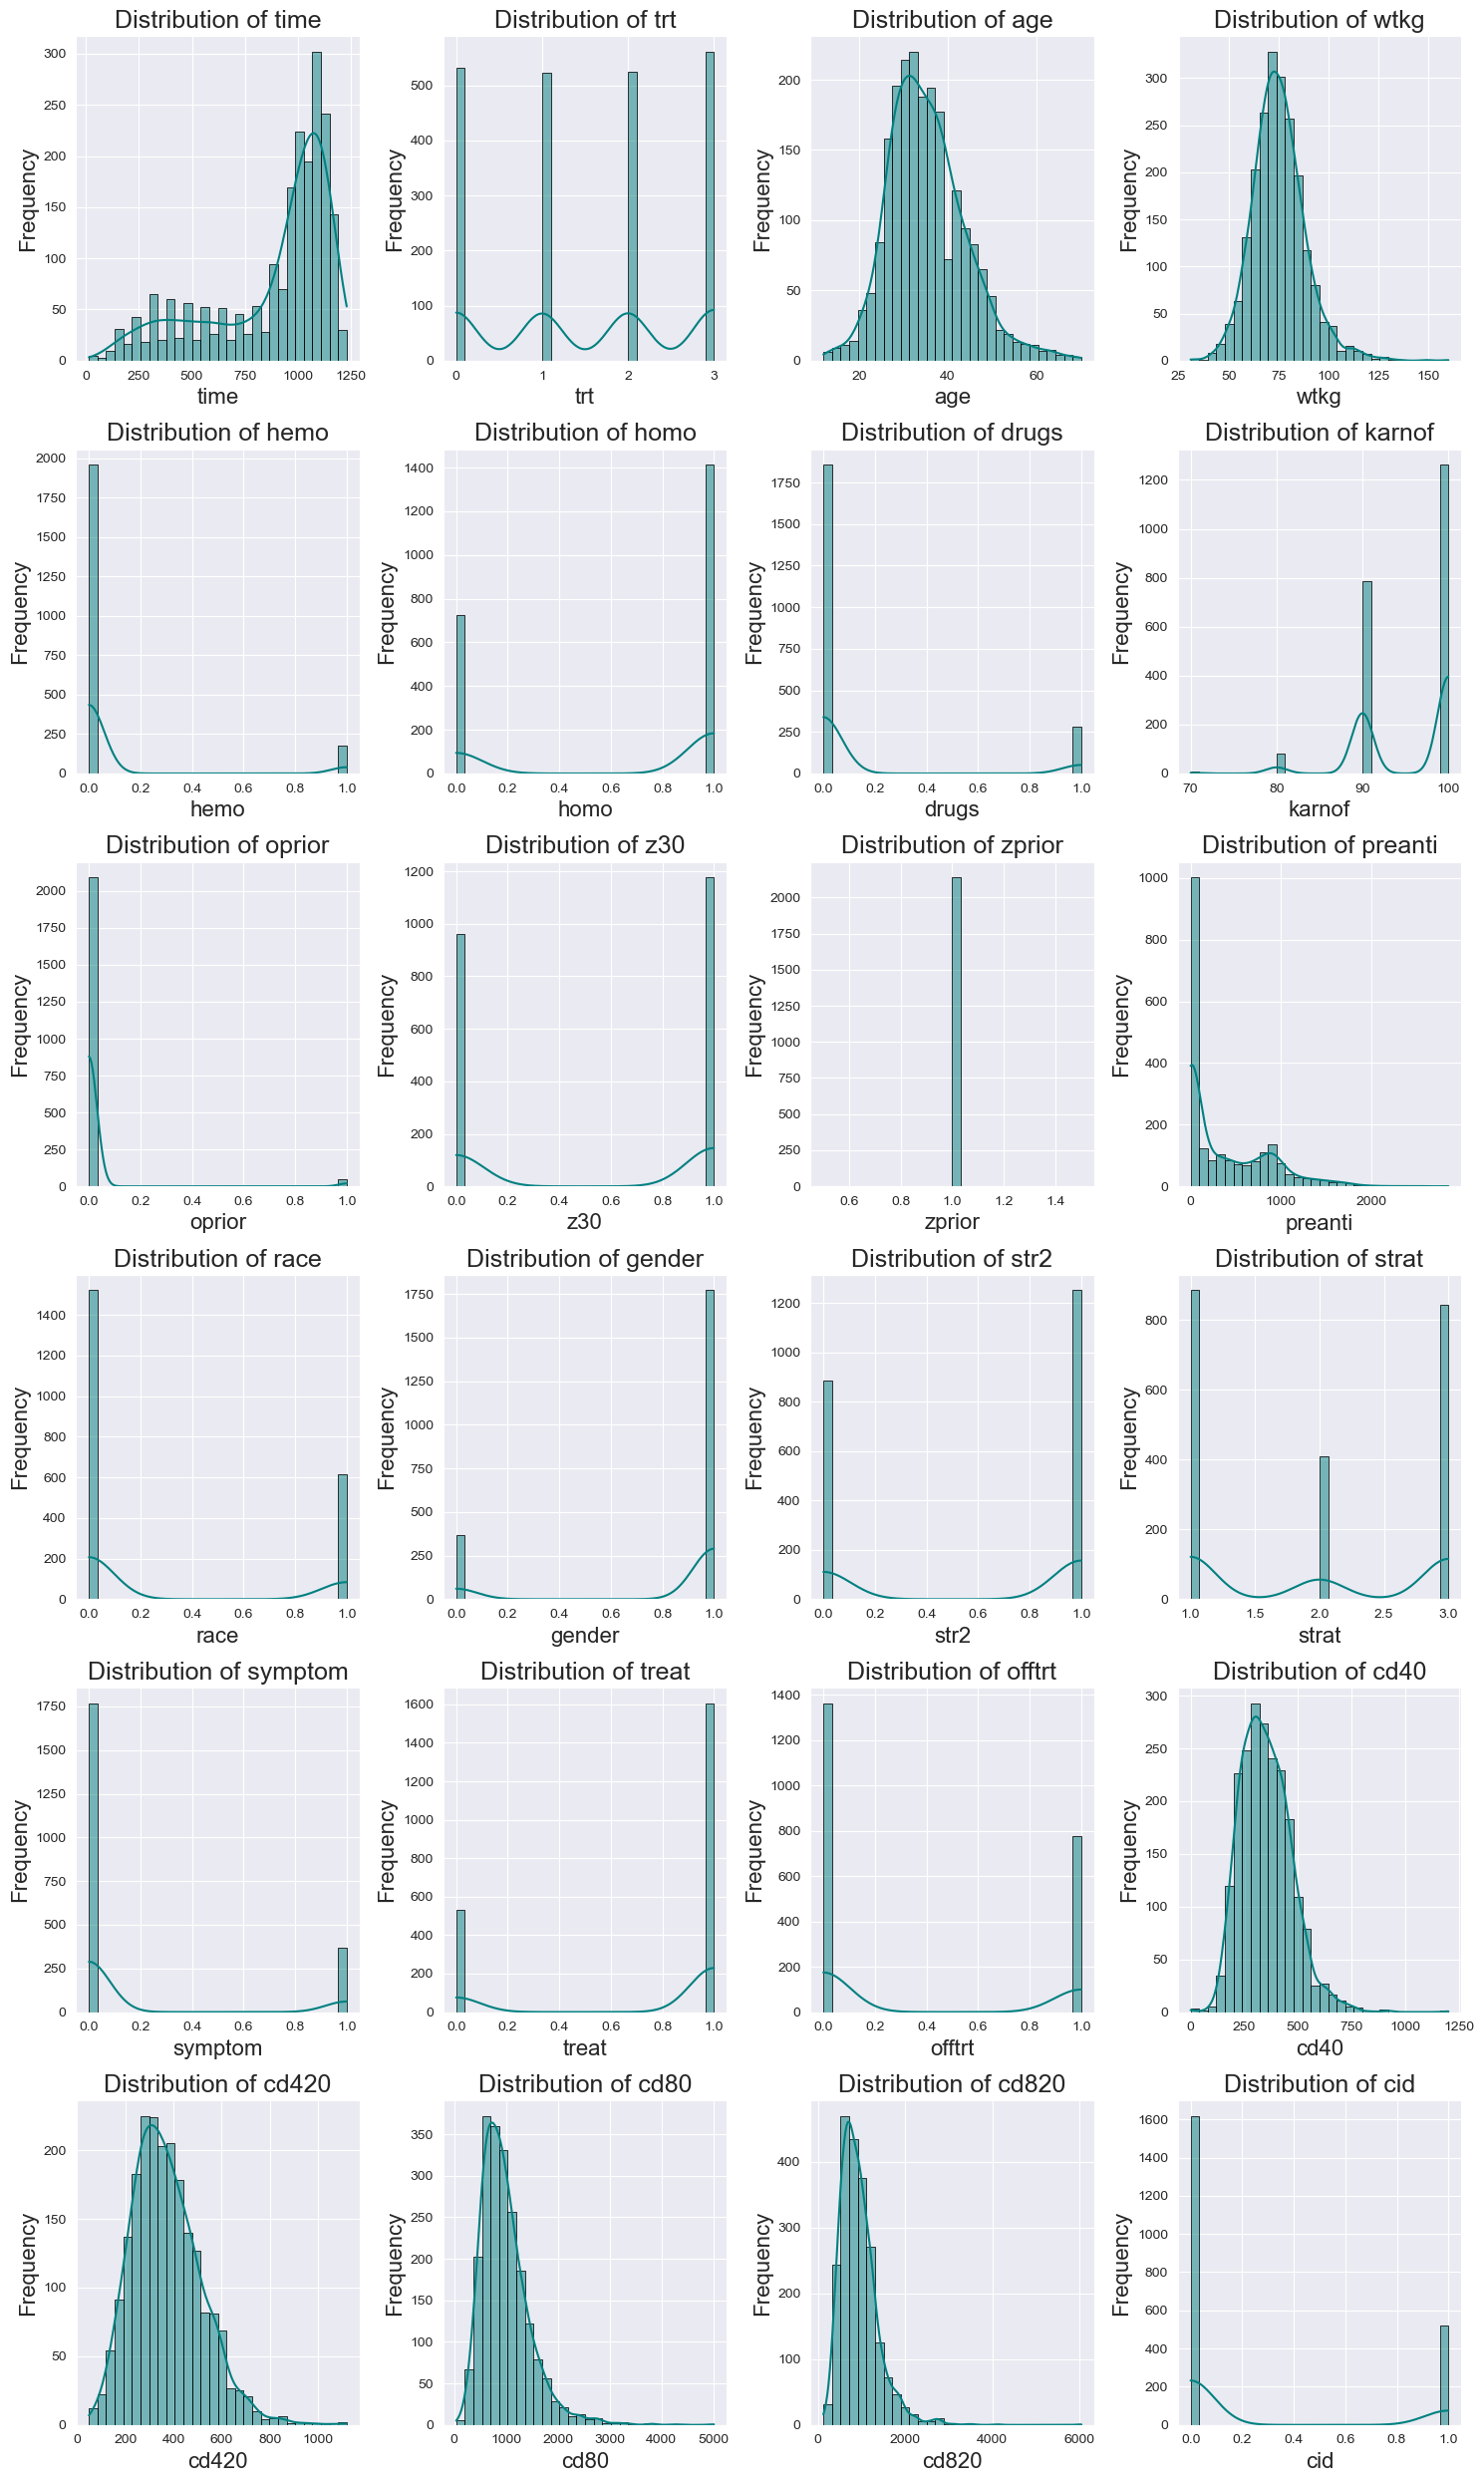

In [16]:
# Plotting histograms for every column in dataframe showing their distribution

plt.figure(figsize=(15, 25))
sns.set_style('darkgrid')

for i, column in enumerate(data.columns):
    plt.subplot(6, 4, i+1)
    sns.histplot(data[column], bins=30, color='teal', edgecolor='black', kde=True)
    plt.title(f'Distribution of {column}', fontsize = 18)
    plt.xlabel(column, fontsize=16)
    plt.ylabel('Frequency', fontsize=16)

plt.tight_layout()
plt.show()

#### Conclusion:
From the histograms, we can observe that most columns are skewed. Additionally, some columns contain only 2 or 3 unique values, indicating an unequal distribution of data. This suggests that certain features may not contribute significantly to predicting the target variable and that the dataset is imbalanced.

***

For features **[homo, hemo, drugs, oprior, z30, zprior, race, gender, str2, symptom, treat, offtrt, cid]** i won't make boxplots because all of them contains binary values (0 and 1)

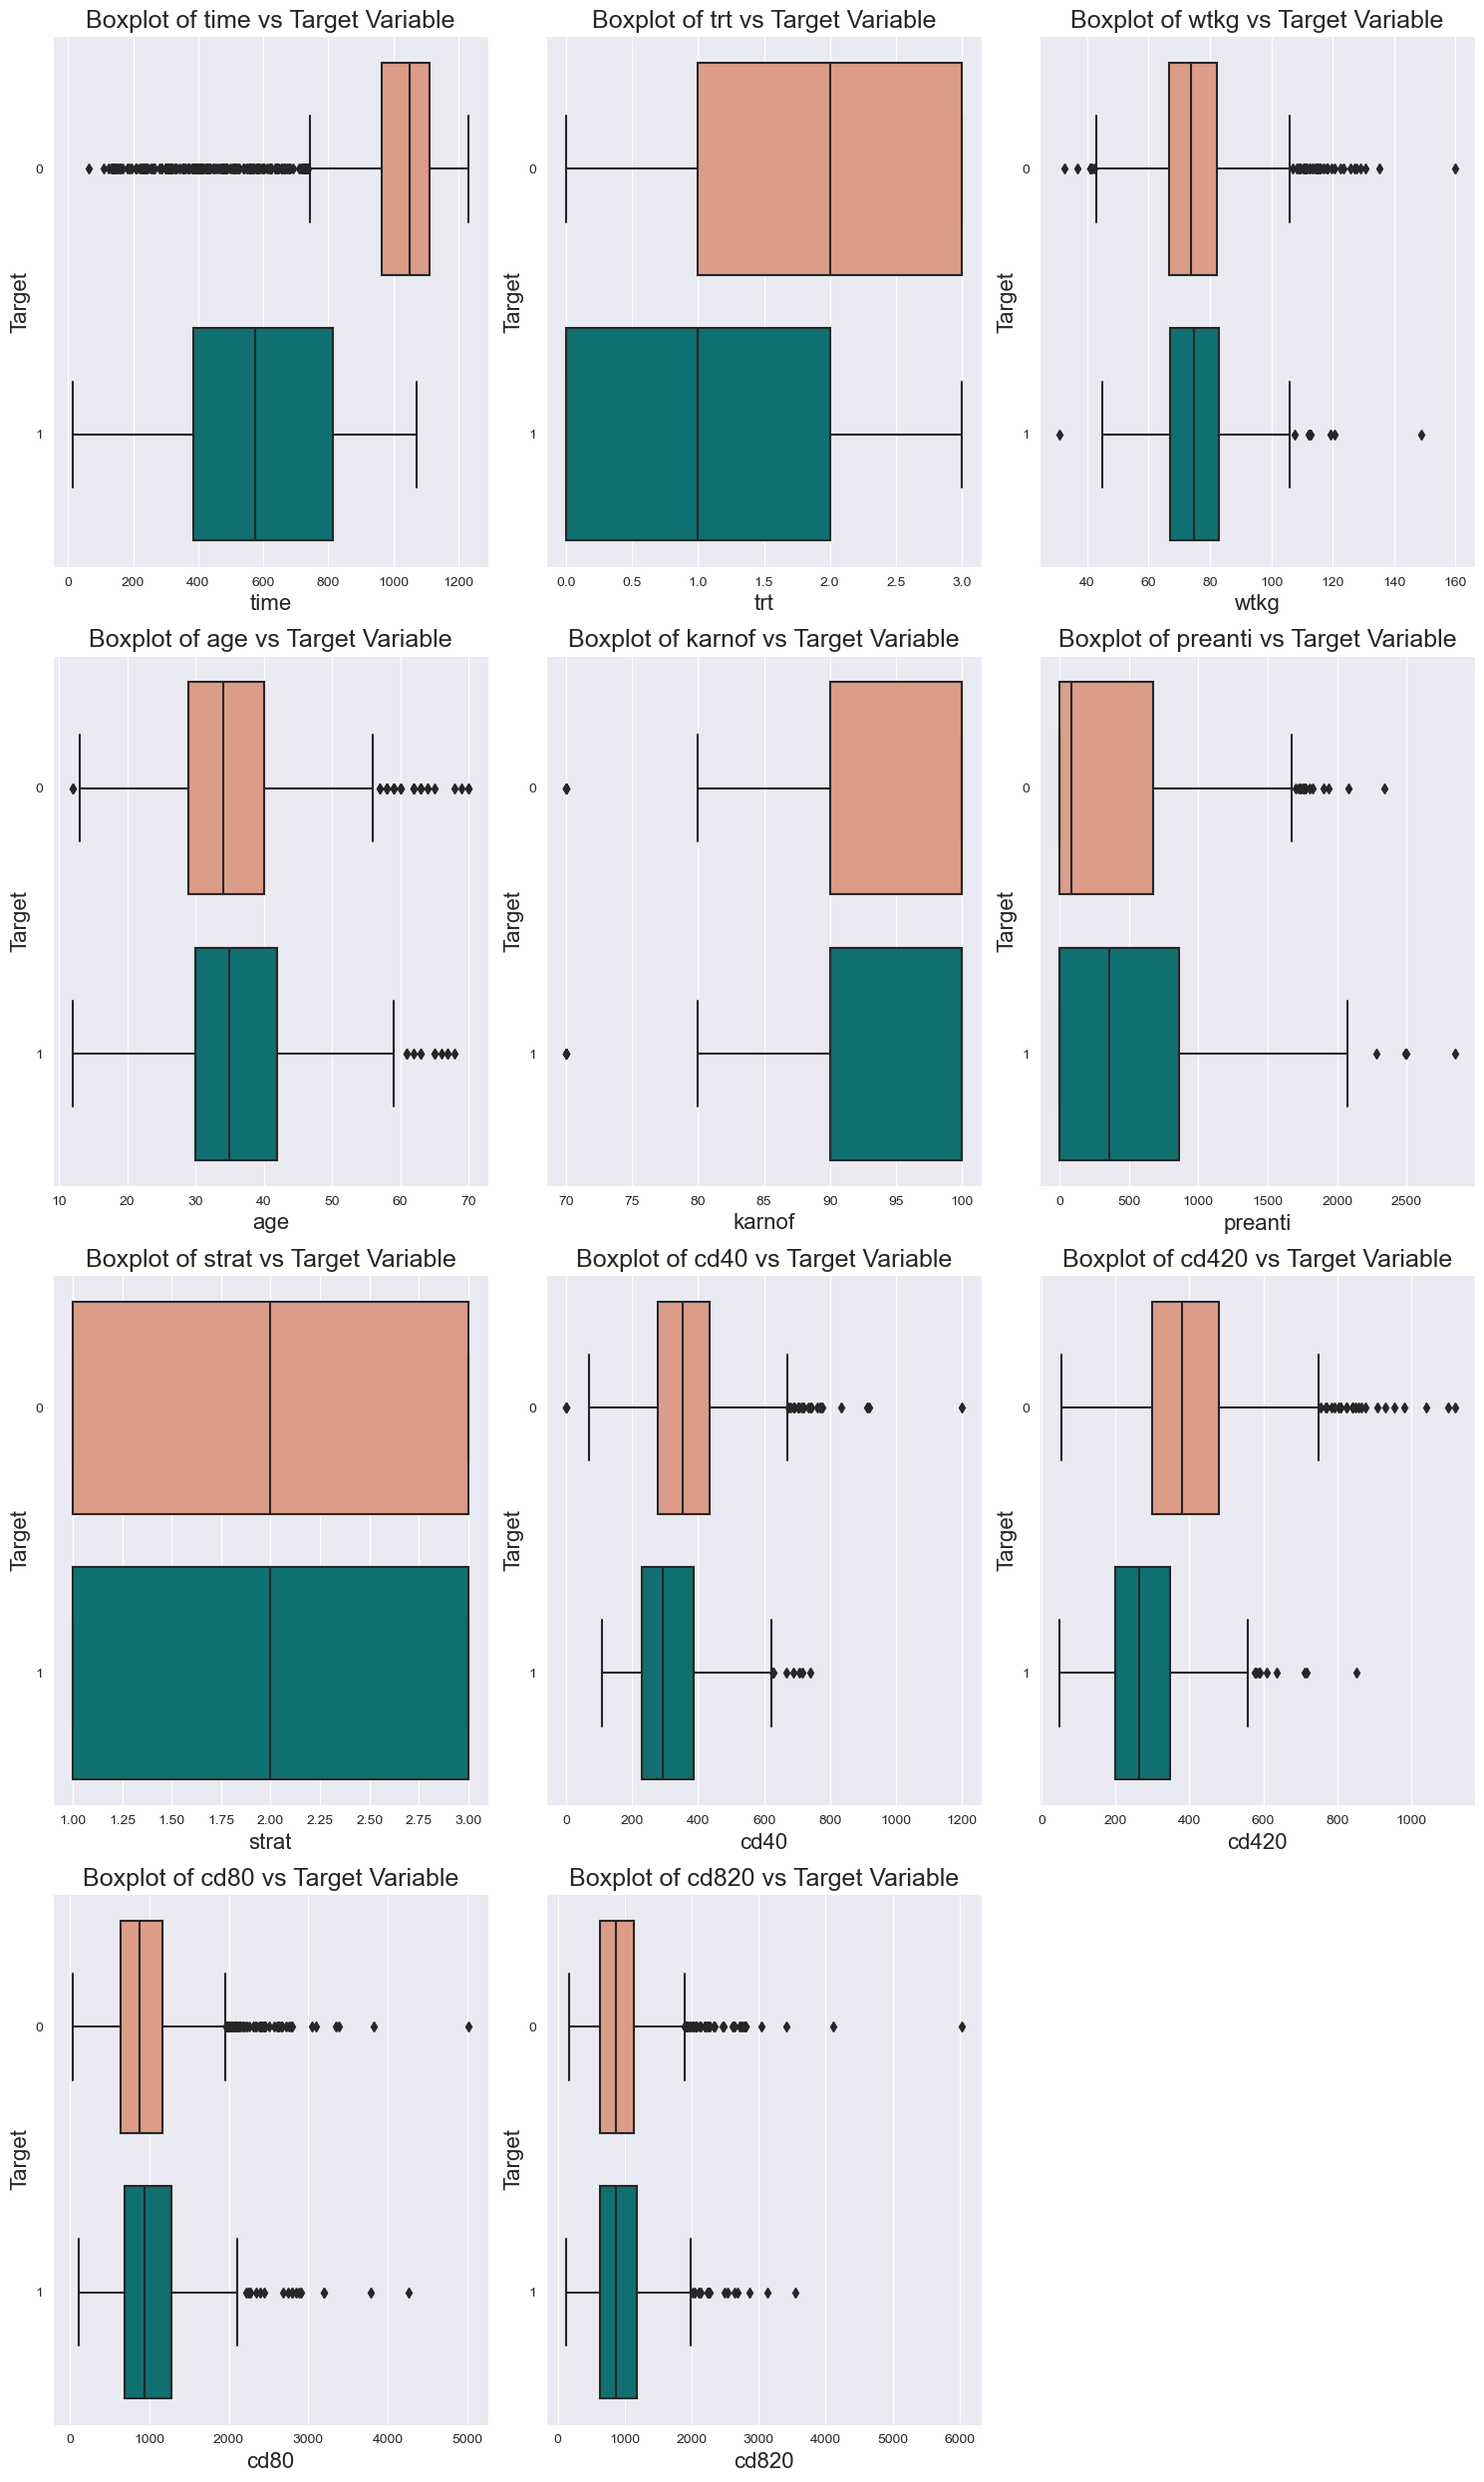

In [36]:
# Boxplots
columns_to_plot = ['time','trt','wtkg','age','karnof','preanti','strat','cd40','cd420','cd80','cd820']

plt.figure(figsize=(15, 25))
sns.set_style('darkgrid')

for i, column in enumerate(columns_to_plot):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x=data[column],y = data['cid'],data=data, orient='h',palette=['darksalmon','teal'])
    plt.title(f'Boxplot of {column} vs Target Variable', fontsize = 18)
    plt.xlabel(column, fontsize=16)
    plt.ylabel('Target', fontsize=16)

plt.tight_layout()
plt.show()


#### Conclusion:
As shown in the boxplots, this dataset contains outliers. Since this is a field in medicine and need consultation with domain expert, for now i won't delete the outliers, as each of them may contain important information. Later i will use SelectKBest Features and models that are more robustness (less sensitive to outliers).

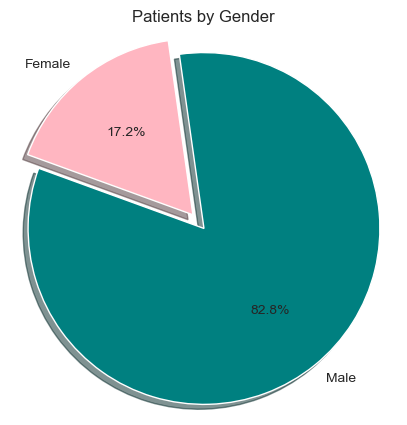

In [108]:
# Patients representation by gender
labels = ['Male', 'Female']
values = data['gender'].value_counts().values
colors = ['teal','lightpink']

# Plot
explode = (0, 0.1)

plt.figure(figsize=(5, 5))
plt.pie(values, labels=labels, colors=colors, startangle=160,autopct='%1.1f%%', shadow=True,explode=explode)
plt.axis('equal')
plt.title('Patients by Gender')
plt.show()

###### Conclusion:
There are more Male patients that developed AIDS than Female


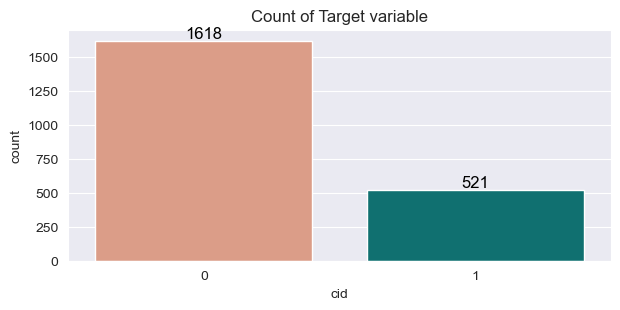

In [28]:
# Target value with count plot
plt.figure(figsize=(7,3))
sns.set_style('darkgrid')
#Plot
pl = sns.countplot(data=data,x = data['cid'],palette=['darksalmon','teal'])
plt.title('Count of Target variable')

# Values
for p in pl.patches:
    pl.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

Target 1 (class 1) constitutes less than 30% of the dataset.This means that we deal with class imbalance, which is very important because it can significantly impact the performance and behavior of models, can lead to biases in model training. There are several techniques that can be used to fix class imbalance, in this task i will use classifiers that perform well on imbalanced datasets.


#### Multivariate Analysis

<Figure size 800x400 with 0 Axes>

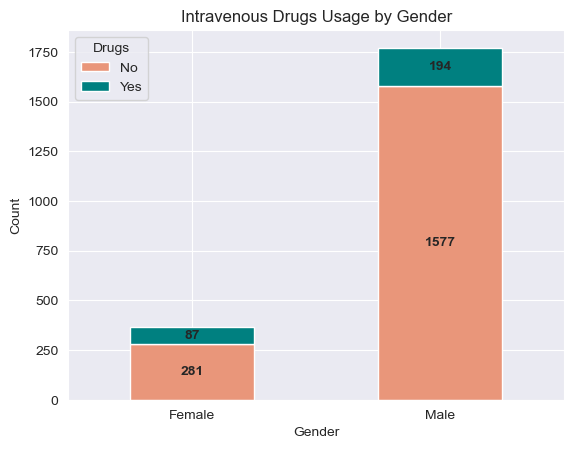

In [105]:
# Drugs Usage by Gender
drugs_df = data.groupby(['gender', 'drugs']).size().unstack()

plt.figure(figsize=(8, 4))
sns.set_style('darkgrid')

#Plot
drugs_df.plot(kind='bar', stacked=True, color=['darksalmon','teal'])
plt.title('Intravenous Drugs Usage by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)  
legend = plt.legend(title='Drugs', loc='upper left', labels = ['No','Yes'])
plt.xticks([0, 1], ['Female', 'Male'])

#values
for i in range(len(drugs_df)):
    for j in range(len(drugs_df.columns)):
        plt.annotate(drugs_df.iloc[i, j], xy=(i, drugs_df.iloc[i, :j].sum() + drugs_df.iloc[i, j] / 2), 
                     ha='center', va='center',fontweight='bold')
plt.show()

<Figure size 800x400 with 0 Axes>

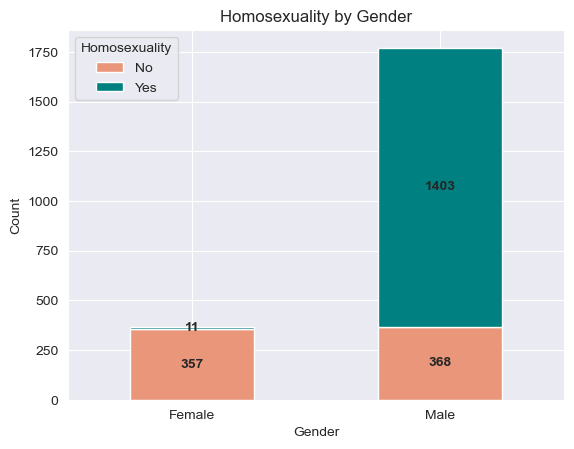

In [104]:
# Homosexuals by gender
homo_df = data.groupby(['gender', 'homo']).size().unstack()

plt.figure(figsize=(8, 4))
sns.set_style('darkgrid')

#Plot
homo_df.plot(kind='bar', stacked=True, color=['darksalmon','teal'])
plt.title('Homosexuality by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)  
legend = plt.legend(title='Homosexuality', loc='upper left',labels = ['No','Yes'])
plt.xticks([0, 1], ['Female', 'Male'])

#Values
for i in range(len(homo_df)):
    for j in range(len(homo_df.columns)):
        plt.annotate(homo_df.iloc[i, j], xy=(i, homo_df.iloc[i, :j].sum() + homo_df.iloc[i, j] / 2), 
                     ha='center', va='center',fontweight='bold')
plt.show()

<Figure size 900x400 with 0 Axes>

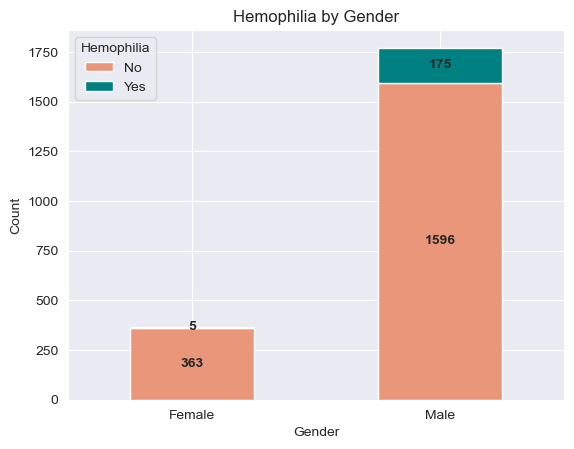

In [103]:
# Hemophilia by gender
hemo_df = data.groupby(['gender', 'hemo']).size().unstack()

plt.figure(figsize=(9, 4))
sns.set_style('darkgrid')

#Plot
hemo_df.plot(kind='bar', stacked=True, color=['darksalmon','teal'])
plt.title('Hemophilia by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)  
legend = plt.legend(title='Hemophilia', loc='upper left',labels = ['No','Yes'])
plt.xticks([0, 1], ['Female', 'Male'])

#values
for i in range(len(hemo_df)):
    for j in range(len(hemo_df.columns)):
        plt.annotate(hemo_df.iloc[i, j], xy=(i, hemo_df.iloc[i, :j].sum() + hemo_df.iloc[i, j] / 2), 
                     ha='center', va='center',fontweight='bold')
plt.show()

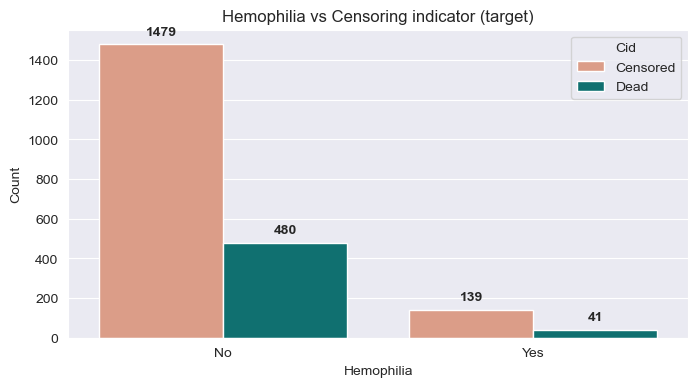

In [101]:
# Hemophilia vs target 
plt.figure(figsize=(8, 4))
sns.set_style('darkgrid')

ax = sns.countplot(data=data, x='hemo', palette=['darksalmon','teal'], hue = 'cid')
plt.title('Hemophilia vs Censoring indicator (target)')
plt.xlabel('Hemophilia')
plt.ylabel('Count')
plt.xticks(rotation=0)  
legend = plt.legend(title='Cid', loc='upper right',labels = ['Censored','Dead'])
plt.xticks([0, 1], ['No', 'Yes'])

#values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points', fontweight = 'bold')
    
plt.show()

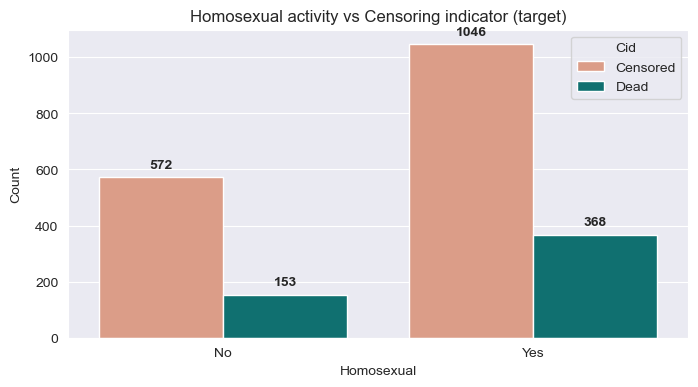

In [100]:
# Homosexual active vs target
plt.figure(figsize=(8, 4))
sns.set_style('darkgrid')

ax = sns.countplot(data=data, x='homo', palette=['darksalmon','teal'], hue = 'cid')
plt.title('Homosexual activity vs Censoring indicator (target)')
plt.xlabel('Homosexual')
plt.ylabel('Count')
plt.xticks(rotation=0)  
legend = plt.legend(title='Cid', loc='upper right',labels = ['Censored','Dead'])
plt.xticks([0, 1], ['No', 'Yes'])

#values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points', fontweight = 'bold')
    
plt.show()

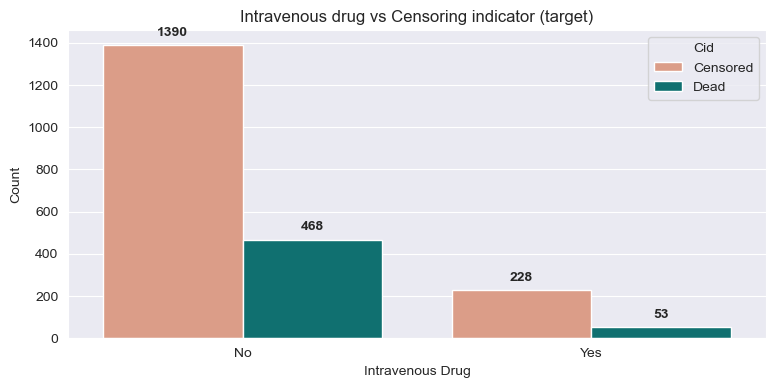

In [99]:
# Drugs Usage vs Target

plt.figure(figsize=(9, 4))
sns.set_style('darkgrid')

ax = sns.countplot(data=data, x='drugs', palette=['darksalmon','teal'], hue = 'cid')
plt.title('Intravenous drug vs Censoring indicator (target)')
plt.xlabel('Intravenous Drug')
plt.ylabel('Count')
plt.xticks(rotation=0)  
legend = plt.legend(title='Cid', loc='upper right',labels = ['Censored','Dead'])
plt.xticks([0, 1], ['No', 'Yes'])

#values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points', fontweight = 'bold')
    
plt.show()

#### Conclusion: 
The reason for plotting these features is due to their relevance in understanding the risk factors for AIDS. Hemophilia is a bleeding disorder, and individuals with hemophilia often require blood transfusions. Unfortunately, some of this blood came from donors infected with HIV or other blood-borne viruses, leading to thousands of people with hemophilia (or those requiring transfusions for other reasons) becoming infected. Therefore, people with hemophilia are at a higher risk of contracting AIDS.

Additionally, it is well-documented that individuals engaging in homosexual activity have an elevated risk of acquiring AIDS. Similarly, intravenous drug users are at a significantly higher risk of contracting AIDS due to the sharing of needles. These factors justify the inclusion of these features in the analysis to better understand the distribution and impact of AIDS among these high-risk groups.

***

#### Analyzing Symptoms and Treatments used

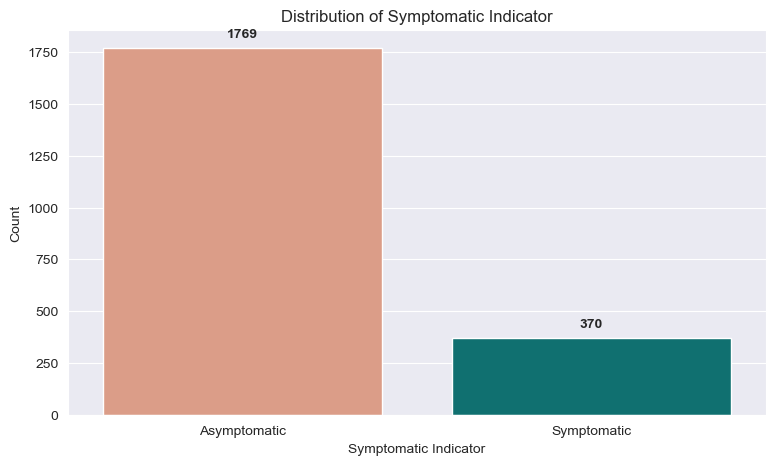

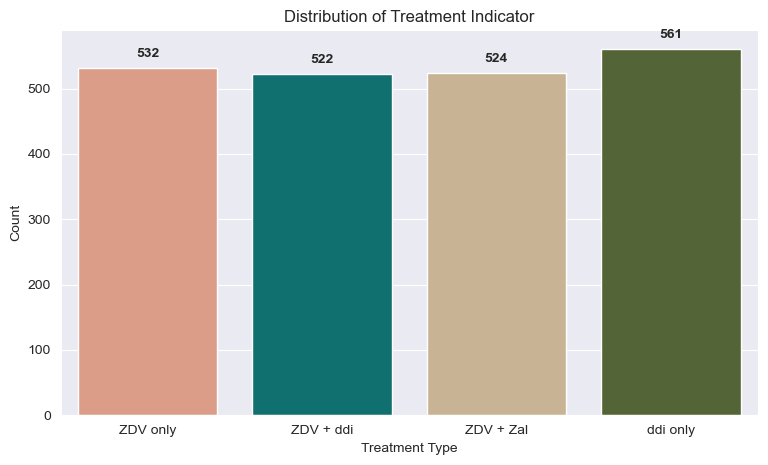

In [97]:
# Symptomatic Indicator
plt.figure(figsize=(9, 5))
sns.set_style('darkgrid')

ax = sns.countplot(data=data, x='symptom', palette=['darksalmon','teal'])
plt.title('Distribution of Symptomatic Indicator')
plt.xlabel('Symptomatic Indicator')
plt.ylabel('Count')
plt.xticks([0, 1], ['Asymptomatic', 'Symptomatic'])

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points', fontweight = 'bold')

    
plt.show()


# Treatment Indicator
plt.figure(figsize=(9, 5))
sns.set_style('darkgrid')

ay = sns.countplot(data=data, x='trt', palette=['darksalmon','teal','tan','darkolivegreen'])
plt.title('Distribution of Treatment Indicator')
plt.xlabel('Treatment Type')
plt.ylabel('Count')
plt.xticks([0, 1, 2, 3], ['ZDV only', 'ZDV + ddi', 'ZDV + Zal', 'ddi only'])

for p in ay.patches:
    ay.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points', fontweight = 'bold')
    
plt.show()

#### Conclusion:
From the first plot, it is evident that a significantly larger number of patients were asymptomatic. Regarding the treatments, they are evenly distributed.
***

#### Analyzing the Impact of Some Features on the Target Column

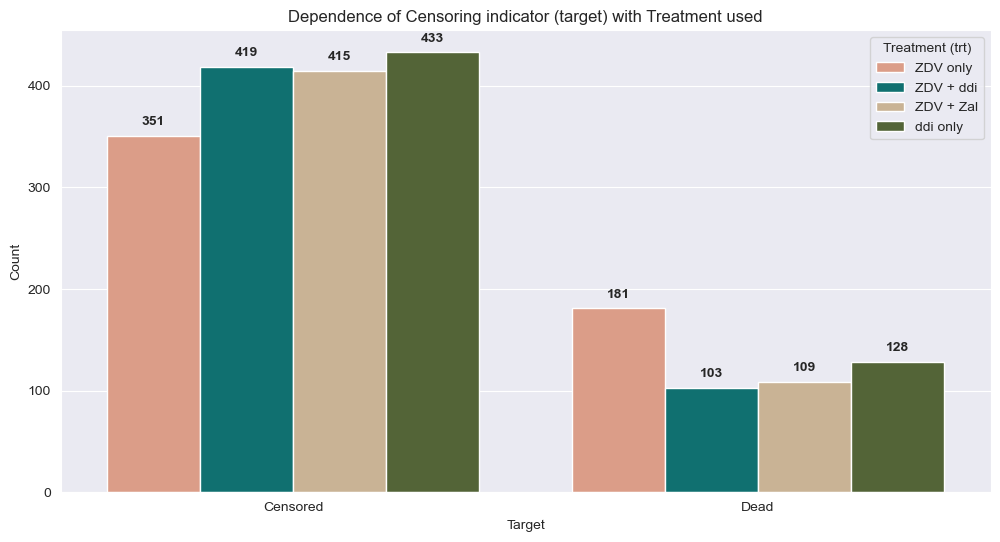

In [28]:
# Target column vs treatment type used
plt.figure(figsize=(12, 6))
sns.set_style('darkgrid')

#Plot
ax = sns.countplot(data=data, x='cid', hue='trt',palette=['darksalmon','teal','tan','darkolivegreen'])

plt.title('Dependence of Censoring indicator (target) with Treatment used')
plt.xlabel('Target')
plt.ylabel('Count')
legend = plt.legend(title='Treatment (trt)')
legend.texts[0].set_text('ZDV only')
legend.texts[1].set_text('ZDV + ddi')
legend.texts[2].set_text('ZDV + Zal')
legend.texts[3].set_text('ddi only')

plt.xticks([0, 1], ['Censored', 'Dead'])

#values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points', fontweight = 'bold')

plt.show()

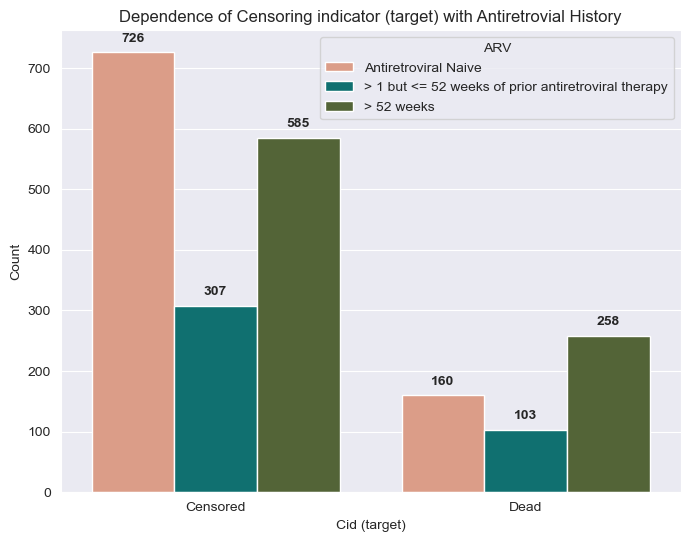

In [30]:
# Target vs antiretroviral history
plt.figure(figsize=(8, 6))
sns.set_style('darkgrid')

#Plot
ax = sns.countplot(data=data, x='cid', hue='strat',palette=['darksalmon','teal','darkolivegreen'])

plt.title('Dependence of Censoring indicator (target) with Antiretrovial History')
plt.xlabel('Cid (target)')
plt.ylabel('Count')
legend = plt.legend(title='ARV', labels = ['Antiretroviral Naive','> 1 but <= 52 weeks of prior antiretroviral therapy','> 52 weeks'])
plt.xticks([0, 1], ['Censored', 'Dead'])

#values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points', fontweight = 'bold')

plt.show()

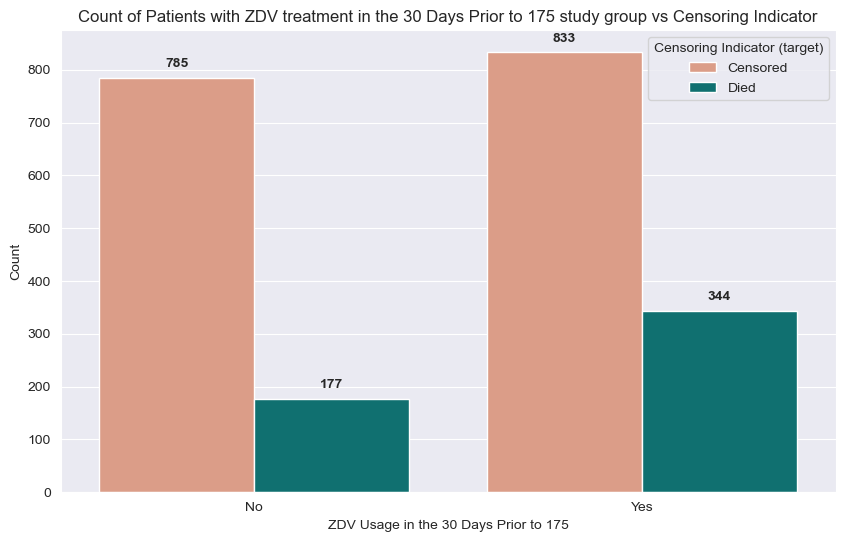

In [94]:
# z30 (zdv in the 30 days prior to 175) vs target
plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')

#Plot
ax = sns.countplot(data=data, x='z30', hue='cid', palette=['darksalmon','teal'])
plt.title('Count of Patients with ZDV treatment in the 30 Days Prior to 175 study group vs Censoring Indicator')
plt.xlabel('ZDV Usage in the 30 Days Prior to 175')
plt.ylabel('Count')
plt.legend(title='Censoring Indicator (target)', labels=['Censored', 'Died'])
plt.xticks([0, 1], ['No', 'Yes'])

#values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points', fontweight = 'bold')
plt.show()

#### Conclusion:

* From the first plot, most of the patients who died were receiving only the ZDV treatment, suggesting that this treatment may not be effective when used alone.

* Based on the antiretroviral therapy:

    Antiretroviral Naive Patients: There are 726 patients who were antiretroviral naive. Among them, 160 patients have  unfortunately passed away.

    Short-term Antiretroviral History: Patients with greater than 0 but less than 52 weeks of prior antiretroviral history total 307. Of these, 103 have passed away.

    Long-term Antiretroviral History: Patients with greater than 52 weeks of prior antiretroviral history total 585. Within this group, 258 patients have passed away.


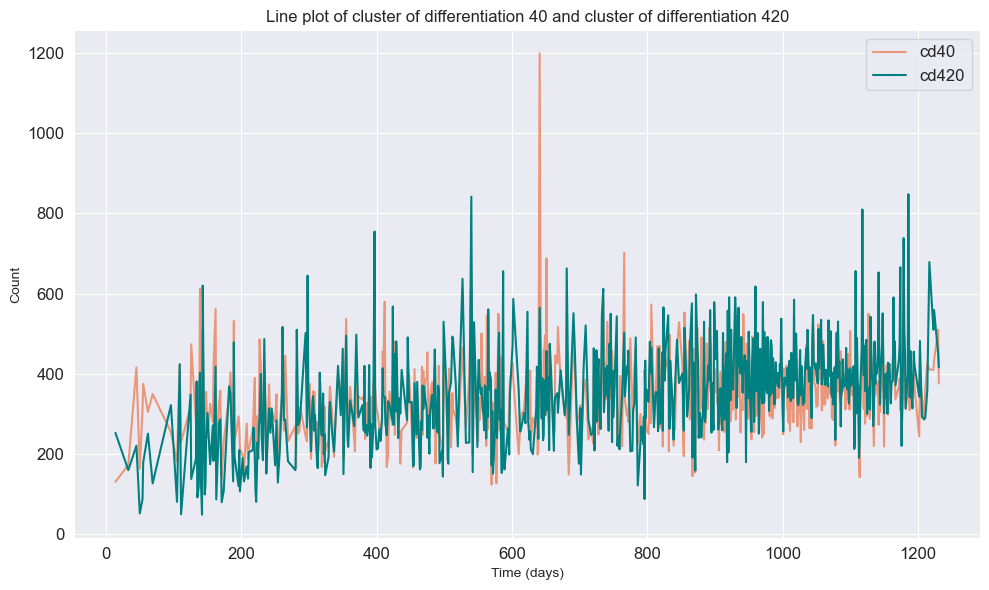

In [32]:
# Plotting cd40 vs cd420 
plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')

sns.lineplot(data=data, x='time', y='cd40',  label='cd40',color='darksalmon',errorbar=('ci', False))
sns.lineplot(data=data, x='time', y='cd420',  label='cd420',color = 'teal',errorbar=('ci', False))
plt.title('Line plot of cluster of differentiation 40 and cluster of differentiation 420')
plt.xlabel('Time (days)')
plt.ylabel('Count')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


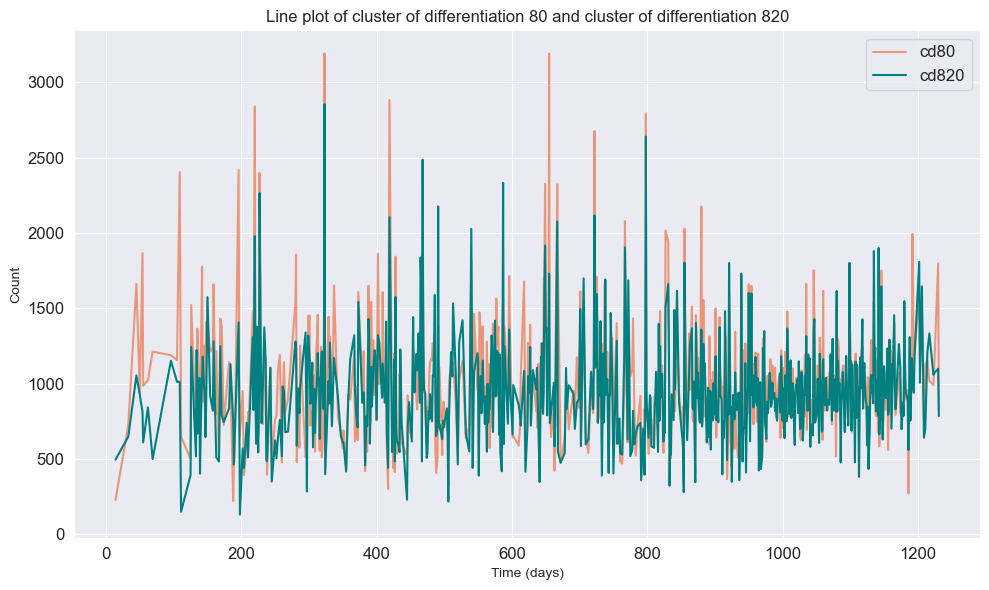

In [33]:
# Plotting cd80 vs cd820 
plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')

#Plot
sns.lineplot(data=data, x='time', y='cd80',  label='cd80',color='darksalmon',errorbar=('ci', False))
sns.lineplot(data=data, x='time', y='cd820',  label='cd820',color = 'teal',errorbar=('ci', False))
plt.title('Line plot of cluster of differentiation 80 and cluster of differentiation 820')
plt.xlabel('Time (days)')
plt.ylabel('Count')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

### Multivariate Analysis

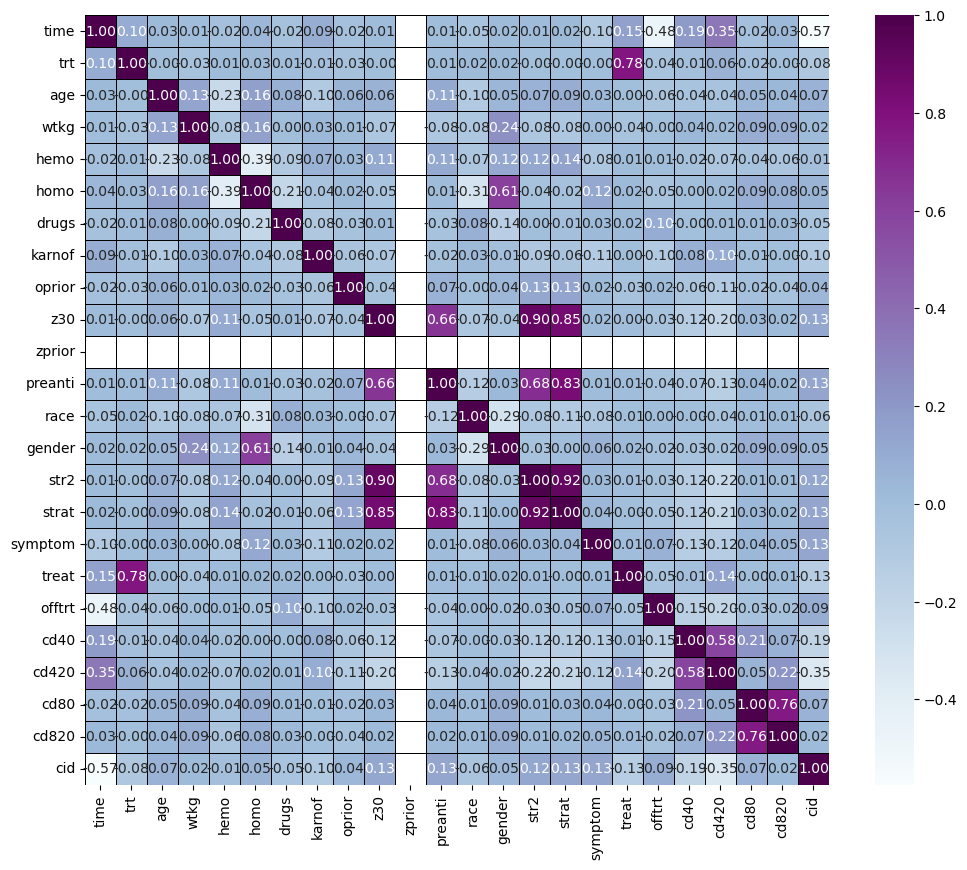

In [21]:
# Correlation matrix

plt.figure(figsize=(12,10))
cmap = sns.color_palette('BuPu', n_colors=5, as_cmap=True)

sns.heatmap(data.corr(), cmap=cmap,annot=True,linewidths=.5,linecolor='black', fmt='.2f', vmax = 1)

plt.show()

What I noticed is that the **zprior column** does not provide any useful information and can be safely deleted later.

Feature that have high correlation with target column is time. Other features are not highly correlated with target.

Given the large number of columns, we won't discuss each one individually. However, we can conclude that certain features are highly correlated:

trt (treatment indicator) with treat (treatment indicator)
z30 (ZDV in the 30 days prior to 175) with str2 (antiretroviral history) and strat (antiretroviral history stratification)
preanti (days pre-175 anti-retroviral therapy) with strat
cd80 (CD8 at baseline) with cd820 (CD8 at 20+/-5 weeks)
These columns should be dropped as they contain similar information due to their high correlation.

In [10]:
# Check if condition is met, where trt is 0, treat must be 0
print((data[data['trt'] == 0]['treat'] == 0).all())

# where trt is different than 0, treat must be 1
print((data[data['trt'] != 0]['treat'] == 1).all())

True
True


As we can see from correlation matrix and whole dataset, features trt and treat have the same meaning. The difference is that in trt we have separate values for every treatment (0 = ZDV only, 1 = ZDV + ddi, 2 = ZDV+ Zal, 3 = ddi only) and in treat we have (0 = ZDV only, 1 = other). Feature **treat** will be dropped. Also features **str2** and **cd820** will be dropped because of the high correlation. 

# **Preprocessing**

Something else that is also important is **skewness** - skewness is a measure of asymmetry in the distribution of values.
The next step will be handling skewed distributions by applying  transformations such as logarithmic, squere root, square and boxcox. For each column specified in skewed_columns i will apply all of this transformers and see which one of them gives best results.

C:\Users\Dell\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Dell\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


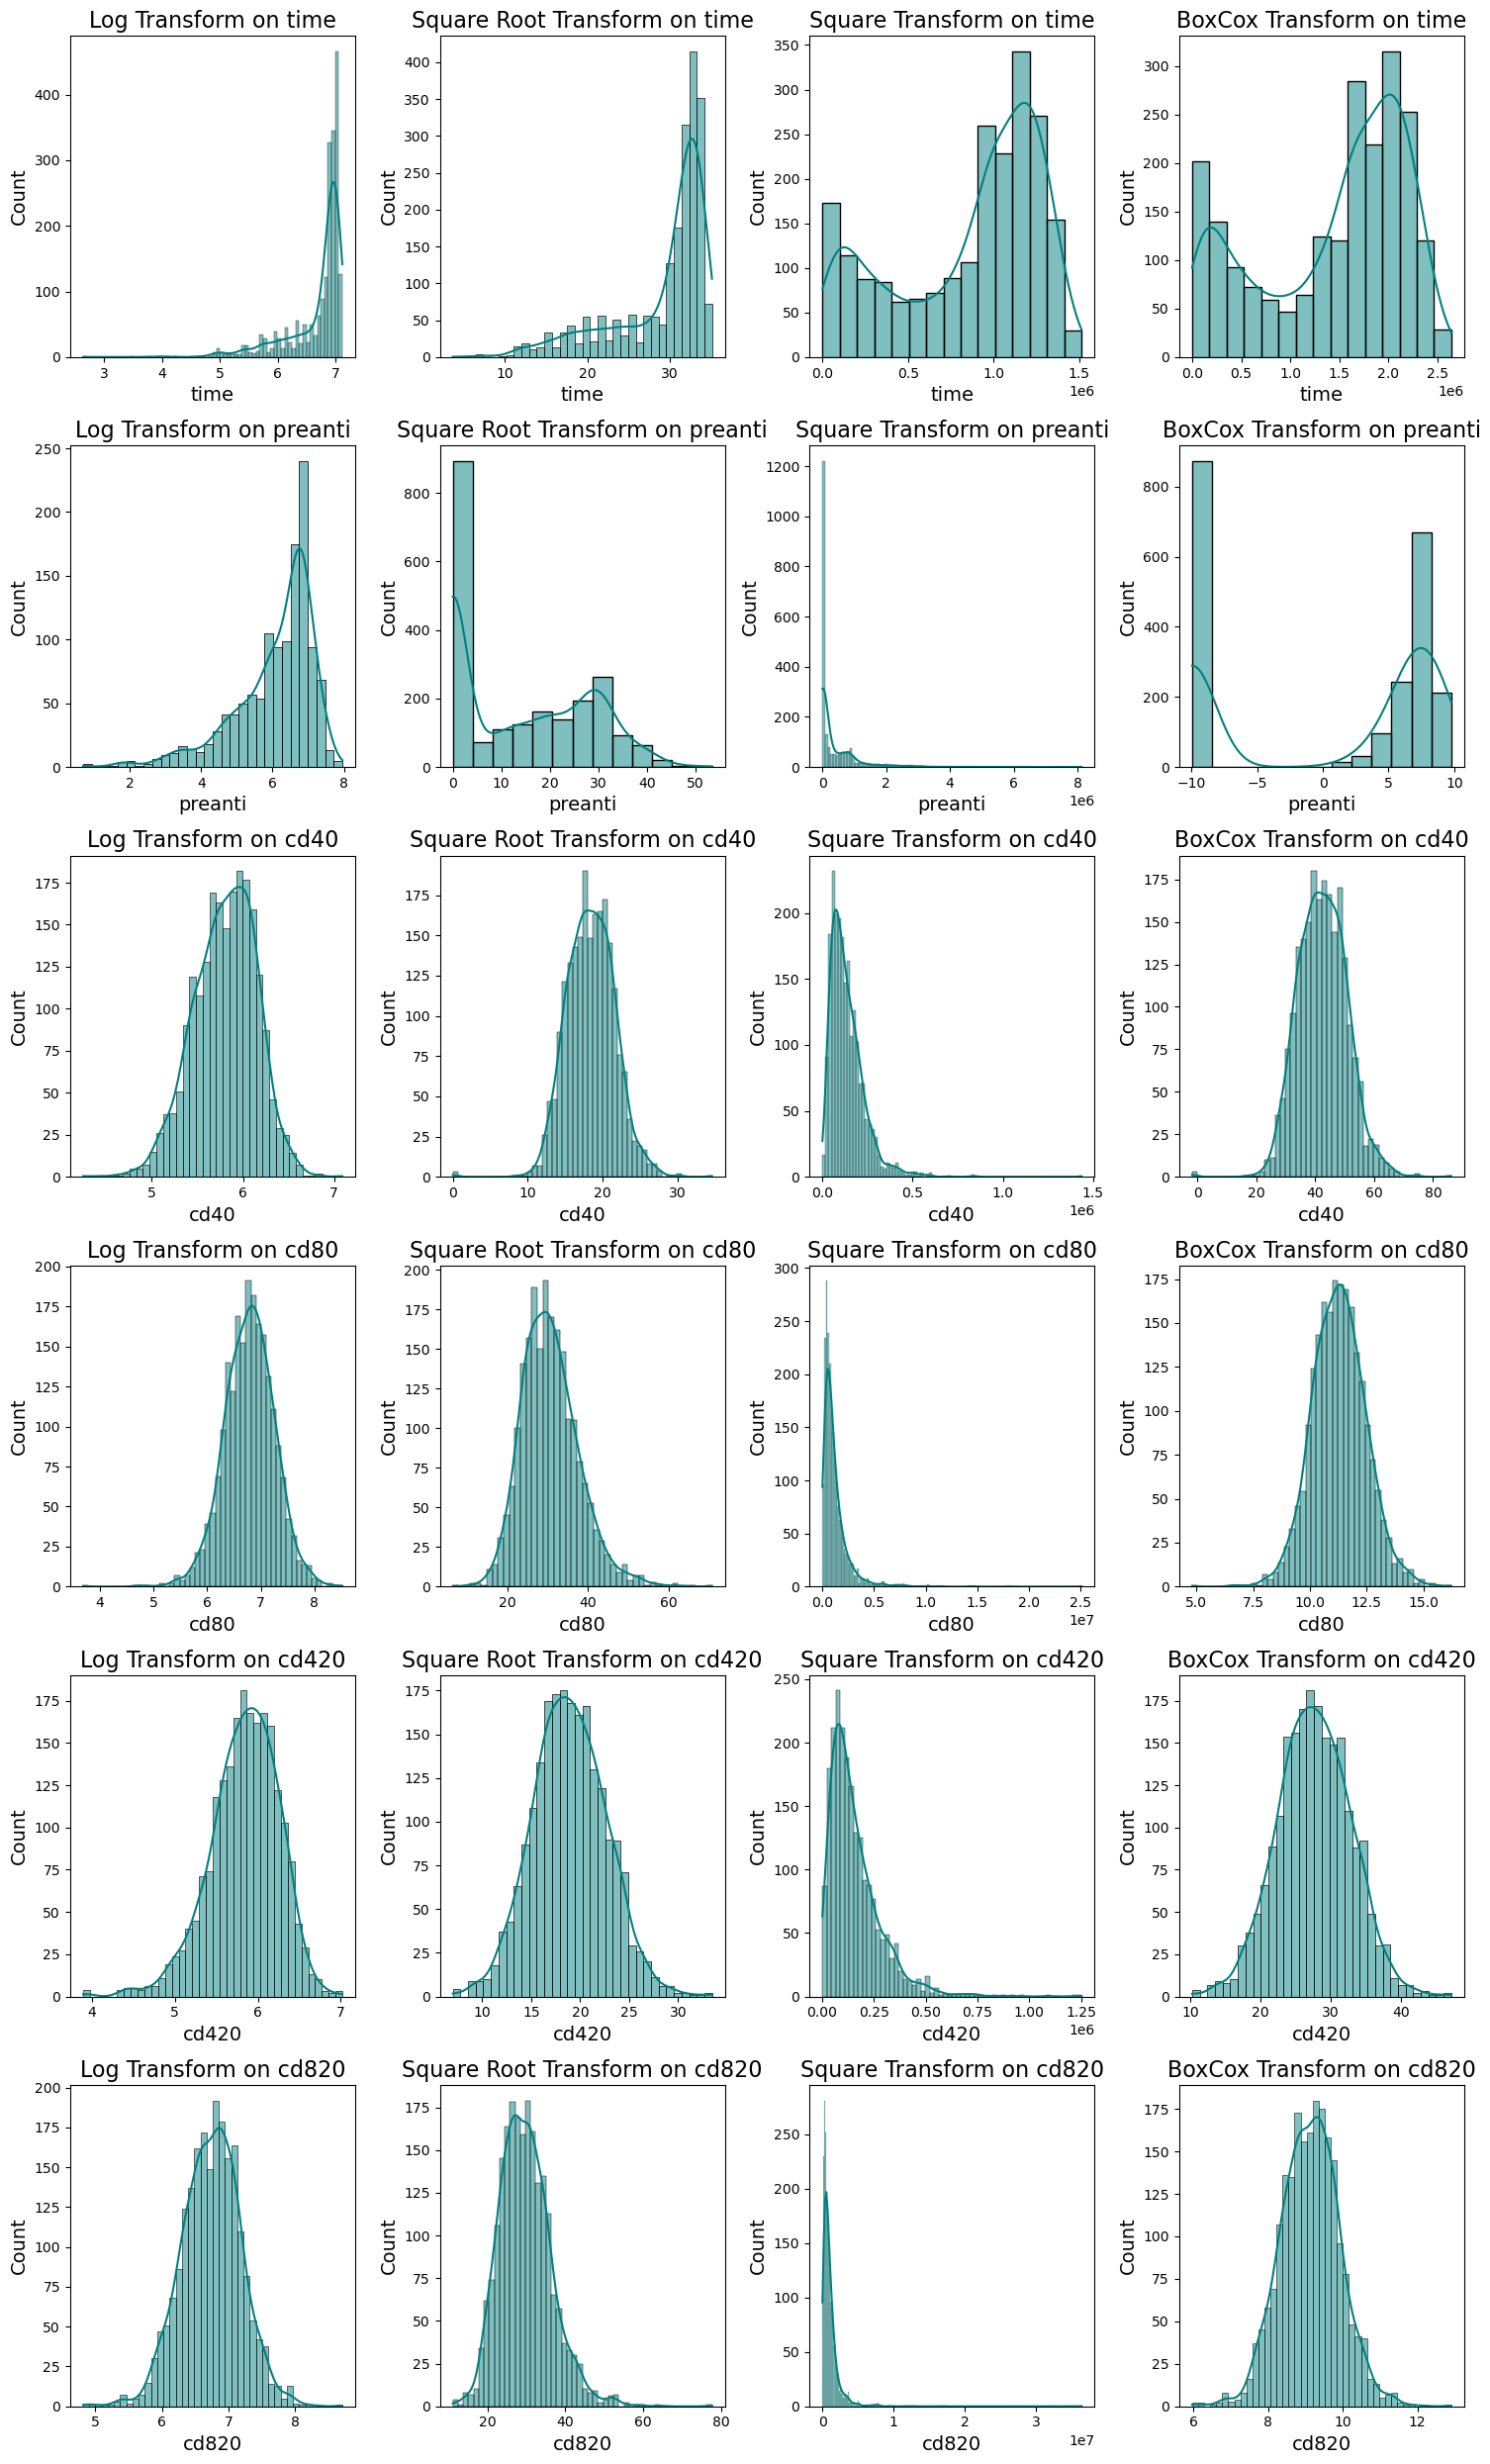

In [16]:
skewed_columns = ['time','preanti','cd40','cd80','cd420','cd820']

# In this step i will define transformers function
transformers = {'Log Transform': np.log,'Square Root Transform': np.sqrt,
                   'Square Transform': np.square,'BoxCox Transform': lambda x: stats.boxcox(x + 1e-6)[0]}

# Plotting transformed skewed columns
plt.figure(figsize=(15, 25))
i = 1
for col in skewed_columns:
    for transform_name, transform_func in transformers.items():
        plt.subplot(6, 4, i)
        sns.histplot(transform_func(data[col]), kde=True, color='teal')
        plt.title(f'{transform_name} on {col}',fontsize = 16)
        plt.xlabel(col,fontsize = 14)
        plt.ylabel('Count',fontsize = 14)
        i += 1

plt.tight_layout()
plt.show()

* Skewnes score

In [17]:
skewness_scores = {}

for col in skewed_columns:
    original_skew = stats.skew(data[col])
    skewness_scores[col] = {'Original Skew': original_skew}

    for transform_name, transform_func in transformers.items():
        transformed_skew = stats.skew(transform_func(data[col]))
        skewness_scores[col][transform_name] = transformed_skew

for col, scores in skewness_scores.items():
    print(f'Column: {col}')
    for transform_name, score in scores.items():
        print(f'{transform_name}: {abs(score)}')
    print()

Column: time
Original Skew: 1.120920884522607
Log Transform: 2.1959660950760487
Square Root Transform: 1.4716986185800778
Square Transform: 0.6906657991794461
BoxCox Transform: 0.6266680482895519

Column: preanti
Original Skew: 1.1905391061792463
Log Transform: nan
Square Root Transform: 0.36358702265316023
Square Transform: 3.5498650576706487
BoxCox Transform: 0.32449655552036855

Column: cd40
Original Skew: 0.7573362495580518
Log Transform: nan
Square Root Transform: 0.045131121237498184
Square Transform: 2.7001386035249917
BoxCox Transform: 0.06305915069220527

Column: cd80
Original Skew: 1.7325198265128143
Log Transform: 0.27582299241446784
Square Root Transform: 0.6976546466697496
Square Transform: 5.50928907560992
BoxCox Transform: 0.018947997054934825

Column: cd420
Original Skew: 0.7298342786811395
Log Transform: 0.6306472215720544
Square Root Transform: 0.09059162758317663
Square Transform: 2.2479657274138893
BoxCox Transform: 0.008712553177985884

Column: cd820
Original Skew:

C:\Users\Dell\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Dell\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1070: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


#### Conclusion:
As we can see box-cox transformation gives best results, except for column cd40 where squere root transformation gives slightly better result than boxcox. I will use box-cox transformation to reduce skewness on these columns.

### Spliting Dataset

In [3]:
# Splitting the data into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,shuffle=True,stratify=y, random_state=42)

In [19]:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(1497, 23) (642, 23)
(1497, 1) (642, 1)


In [20]:
# Calculation in % of class imbalance/balance
print(100*y_train['cid'].value_counts()/len(y_train['cid']))

cid
0    75.617902
1    24.382098
Name: count, dtype: float64


In [21]:
X_train.shape[0]/X.shape[0] 

0.699859747545582

##### Defining Preprocessing Pipeline - baseline pipeline

* In the following code i will use VarianceThreshold that is a simple baseline approach. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features.

  Also i will define classes, one that drops certain column from dataset and the other for applying skewness.

In [4]:
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_df = pd.DataFrame(X)
        X_df.drop(columns=self.columns_to_drop, inplace=True, errors='ignore')
        X_np = X_df.to_numpy()
        
        return X_np

In [5]:
class SkewedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns = None):
        self.columns = columns
        
    def fit(self,X,y=None):
        return self
    
    def transform(self, X, y=None):
        X_df = pd.DataFrame(X)  
        for col in self.columns:
            X_df[col] = stats.boxcox(X_df[col] + 1e-6)[0]

        return X_df

In [48]:
# skew_transformer = SkewedTransformer(columns=skewed_columns)
# X_train = skew_transformer.transform(X_train)
# X_train

In [6]:
base_pipe = Pipeline(steps = [('remove_col_std0', VarianceThreshold()),
#                             ('skew_transform', SkewedTransformer(columns=skewed_columns)), not helping
                              ('drop_columns', DropColumnsTransformer(columns_to_drop=['treat','str2','cd820'])),
                              ('imputer',SimpleImputer(strategy='mean')), #if any null values are incoming populate them with mean
                              ('scaler', MinMaxScaler())])

## Define Models and HyperParameters

I wll choose models that are less sensitive to class imbalance. Those are: DecisionTree, RandomForest, AdaBoost, XGBoost. And i will use three different methods for hyperparameters tuning: GridSearchCV, Bayesian and GeneticCV.

In [7]:
# Define models
models = [DecisionTreeClassifier(),RandomForestClassifier(),AdaBoostClassifier(),XGBClassifier()]
models_names = ['dt','rf','ada','xgb']

In [8]:
# Dummy Classifier (as baseline)
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)

# Train the Dummy Classifier
dummy_clf.fit(X_train, y_train.values.ravel())

# Make predictions on the test set
y_pred = dummy_clf.predict(X_test)

# Compute the F1 score
f1 = f1_score(y_test.values.ravel(), y_pred)
accuarcy = accuracy_score(y_test.values.ravel(), y_pred)

print("F1 score:", f1)
print("Accuracy", accuarcy)

F1 score: 0.0
Accuracy 0.7570093457943925


### GridSearchCV

Because GridSearch is computationally expensive, especially when dealing with a large number of hyperparameters and their possible values, i will write less options in parameter_grid.

I will use evaluation metric F1 score because i have medicine dataset.

In [19]:
# Defining parameters
dt_param_grid = {'select_k_best__k':[10,15,20],
                 'model__max_depth': [2,5,7,10,15],
                 'model__criterion': ["gini", "entropy"],
                 'model__min_samples_split': [2,5,10],
                 'model__min_samples_leaf' : [3,5],
                 'model__random_state': [42]}

rf_param_grid = {'select_k_best__k':[10,15,20],
                 'model__n_estimators': range(50,200,50),
                 'model__max_depth': [2,5,10,15],
                 'model__criterion': ["gini", "entropy"],
                 'model__min_samples_split': [2,5,10],
                 'model__min_samples_leaf' : [3,5],
                 'model__random_state': [42]}

adb_param_grid = {'select_k_best__k':[10,15,20],
                  'model__n_estimators': range(50,200,50),  
                  'model__learning_rate': [0.01, 0.1, 1.0],
                  'model__random_state': [42]}

xgb_param_grid = {'select_k_best__k':[10,15,20],
                  'model__n_estimators':range(50,200,50),
                  'model__max_depth':[2,5,10,15], 
                  'model__random_state': [42]}

# Parameters
model_params = [dt_param_grid,rf_param_grid,adb_param_grid,xgb_param_grid]

In [14]:
# GridSEarch definition
grid_cv = []
for model_name, model, model_params in zip(models_names,models,model_params):
    
    # KFold cross validation with 3 splits to avoid long execution
    skf = StratifiedKFold(n_splits = 3,shuffle = True, random_state=42) 
    
    print('Currently fitting: ', model_name)
    
    base_pipe_grid = Pipeline(steps = [('preprocessing',base_pipe),
                                       ('select_k_best', SelectKBest(f_classif)),
                                       ('model',model)]) 
    # Define gridsearch
    pipe_grid = GridSearchCV(base_pipe_grid, model_params, cv = skf,
                             verbose = 2, n_jobs=-1,scoring='f1',error_score='raise') 
    
    #Fit
    pipe_grid.fit(X_train,y_train.values.ravel())

    # Score
    print('Search finished, best parameters: ')
    print(pipe_grid.best_params_)
    grid_cv.append([model_name, pipe_grid.best_params_, pipe_grid.best_score_ ])

Currently fitting:  dt
Fitting 3 folds for each of 180 candidates, totalling 540 fits
Search finished, best parameters: 
{'model__criterion': 'entropy', 'model__max_depth': 5, 'model__min_samples_leaf': 3, 'model__min_samples_split': 2, 'model__random_state': 42, 'select_k_best__k': 15}
Currently fitting:  rf
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Search finished, best parameters: 
{'model__criterion': 'gini', 'model__max_depth': 15, 'model__min_samples_leaf': 3, 'model__min_samples_split': 10, 'model__n_estimators': 150, 'model__random_state': 42, 'select_k_best__k': 20}
Currently fitting:  ada
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Search finished, best parameters: 
{'model__learning_rate': 0.1, 'model__n_estimators': 100, 'model__random_state': 42, 'select_k_best__k': 20}
Currently fitting:  xgb
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Search finished, best parameters: 
{'model__max_depth': 2, 'model__n_estimators':

In [16]:
# Results
grid_df = pd.DataFrame(grid_cv, columns=['model_name','best_parameters','best_score'])
grid_df.sort_values('best_score',ascending=False)

,model_name,best_parameters,best_score
1,rf,"{'model__criterion': 'gini', 'model__max_depth...",0.756518
2,ada,"{'model__learning_rate': 0.1, 'model__n_estima...",0.752005
3,xgb,"{'model__max_depth': 2, 'model__n_estimators':...",0.750855
0,dt,"{'model__criterion': 'entropy', 'model__max_de...",0.738515


### Bayesian Optimization



In [31]:
# Step 1: define parameters
dt_param_grid_bo = {'select_k_best__k': hp.choice('select_k_best__k', list(np.arange(5, 20, 5))),
                    'model__max_depth': hp.choice('model__max_depth', list(np.arange(1, 20, 2))),
                    'model__criterion': hp.choice('model__criterion', ['gini', 'entropy']),
                    'model__min_samples_split': hp.choice('model__min_samples_split', list(np.arange(2, 20, 2))),
                    'model__min_samples_leaf': hp.choice('model__min_samples_leaf', list(np.arange(1, 10))),
                    'model__max_features': hp.choice('model__max_features', ['sqrt', None]),
                    'model__random_state': hp.choice('model__random_state',[42])}

rf_param_grid_bo = {'select_k_best__k': hp.choice('select_k_best__k', list(np.arange(5, 20, 5))),
                    'model__n_estimators': hp.choice('model__n_estimators', range(50, 200, 50)),
                    'model__max_depth': hp.choice('model__max_depth', list(np.arange(1, 20, 2))),
                    'model__criterion': hp.choice('model__criterion', ['gini', 'entropy']),
                    'model__min_samples_split': hp.choice('model__min_samples_split', list(np.arange(2, 20, 2))),
                    'model__min_samples_leaf': hp.choice('model__min_samples_leaf', list(np.arange(1, 10, 1))),
                    'model__max_features': hp.choice('model__max_features', ['sqrt', None]),
                    'model__random_state': hp.choice('model__random_state',[42])}

adb_param_grid_bo = {'select_k_best__k': hp.choice('select_k_best__k', list(np.arange(5, 20, 5))),
                     'model__n_estimators': hp.choice('model__n_estimators', np.arange(50, 200, 50)),
                     'model__learning_rate': hp.choice('model__learning_rate', np.arange(0.01, 1.1, 0.1)),
                     'model__random_state': hp.choice('model__random_state',[42])}

xgb_param_grid_bo = {'select_k_best__k': hp.choice('select_k_best__k', list(np.arange(5, 20, 5))),
                    'model__n_estimators': hp.choice('model__n_estimators', range(50, 200, 50)),
                    'model__max_depth': hp.choice('model__max_depth', list(np.arange(1, 10, 1)) + [None]),
                    'model__learning_rate': hp.choice('model__learning_rate', np.arange(0.01, 1.1, 0.1)),
                    'model__gamma': hp.choice('model__gamma', np.arange(0.0, 0.5, 0.1)),
                    'model__reg_alpha': hp.choice('model__reg_alpha', np.logspace(-4, 1, 6)),
                    'model__reg_lambda': hp.choice('model__reg_lambda', np.logspace(-4, 1, 6)), 
                    'model__random_state': hp.choice('model__random_state',[42])}

model_params_bo = [dt_param_grid_bo,rf_param_grid_bo,adb_param_grid_bo,xgb_param_grid_bo]

In [33]:
skf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)

def objective(space):
    base_pipe_grid.set_params(**space)
    score = cross_val_score(base_pipe_grid, X_train, y_train.values.ravel(), cv = skf, scoring='f1').mean()
    return {'loss':-score, 'status': STATUS_OK}

# Bayesian search
report_bo = []
for model_name, model,model_prams in zip(models_names, models, model_params_bo):
    print('Currently fitting: ', model_name)
    
    base_pipe_grid = Pipeline(steps = [('preprocessing', base_pipe),
                                       ('select_k_best', SelectKBest(f_classif)),
                                       ('model', model)
                                        ])
    trials = Trials()
    best_params = fmin(fn = objective, space = model_prams, algo=tpe.suggest, max_evals = 50, trials=trials)
    
    best_score = 0
    for trial in trials.trials:
        best_score = max(best_score, -trial['result']['loss'])
    
    print('Search finished, best parameters:')
    print(space_eval(model_prams, best_params))
    print('Best score:', best_score)
    
    report_bo.append([model_name, best_params, best_score])

Currently fitting:  dt
100%|██████████| 50/50 [00:05<00:00,  9.10trial/s, best loss: -0.7522159018340193]
Search finished, best parameters:
{'model__criterion': 'entropy', 'model__max_depth': 3, 'model__max_features': None, 'model__min_samples_leaf': 9, 'model__min_samples_split': 10, 'model__random_state': 42, 'select_k_best__k': 15}
Best score: 0.7522159018340193
Currently fitting:  rf
100%|██████████| 50/50 [01:47<00:00,  2.15s/trial, best loss: -0.767953993631779] 
Search finished, best parameters:
{'model__criterion': 'entropy', 'model__max_depth': 5, 'model__max_features': None, 'model__min_samples_leaf': 9, 'model__min_samples_split': 8, 'model__n_estimators': 100, 'model__random_state': 42, 'select_k_best__k': 15}
Best score: 0.767953993631779
Currently fitting:  ada
100%|██████████| 50/50 [01:03<00:00,  1.27s/trial, best loss: -0.7545669719495018]
Search finished, best parameters:
{'model__learning_rate': 0.21000000000000002, 'model__n_estimators': 50, 'model__random_state': 4

In [35]:
#Crating dataframe from results
bo_df = pd.DataFrame(report_bo, columns=['model_name','best_parameters', 'best_score'])
bo_df.sort_values('best_score',ascending=False)

,model_name,best_parameters,best_score
1,rf,"{'model__criterion': 1, 'model__max_depth': 2,...",0.767954
3,xgb,"{'model__gamma': 3, 'model__learning_rate': 3,...",0.765127
2,ada,"{'model__learning_rate': 2, 'model__n_estimato...",0.754567
0,dt,"{'model__criterion': 1, 'model__max_depth': 1,...",0.752216


### GASearchCV

When we fit GA Search algorithm we will see metrics it’s achieving at each generation. The “fitness” refers to the metric we chose in this case i will choose f1 score.  As the algorithm uses more than one set of hyperparameters per generation, it shows the average score, standard deviation, and maximum and minimum individual values.

In [36]:
#Defining parameters
dt_param_grid_ga = {'select_k_best__k': Integer(5,20),
                    'model__max_depth': Integer(1, 20),
                    'model__criterion': Categorical(["gini", "entropy"]),
                    'model__min_samples_split' : Integer(2,20),
                    'model__min_samples_leaf' : Integer(1,10),
                    'model__random_state': Integer(42,43)}

rf_param_grid_ga = {'select_k_best__k': Integer(5,20),
                    'model__n_estimators': Integer(1,150),
                    'model__min_samples_split' : Integer(2,20),
                    'model__min_samples_leaf' : Integer(1,10),
                    'model__max_depth': Integer(1, 20),
                    'model__criterion': Categorical(["gini", "entropy"]),
                    'model__random_state': Integer(42,43)}

adb_param_grid_ga = {'select_k_best__k': Integer(5,20),
                     'model__n_estimators': Integer(1,150),  
                     'model__learning_rate': Continuous(0.01,1.0),
                     'model__random_state': Integer(42,43)}

xgb_param_grid_ga = {'select_k_best__k': Integer(5,20),
                     'model__n_estimators': Integer(1,100),
                     'model__max_depth': Integer(1, 10),
                     'model__random_state': Integer(42,43)}

# Making list of all parameters for later use
model_params_ga = [dt_param_grid_ga,rf_param_grid_ga,adb_param_grid_ga,xgb_param_grid_ga]

In [37]:
#GASearchCV definition
report_ga = []
for model_name, model,model_prams in zip(models_names, models, model_params_ga):
    
    skf = StratifiedKFold(n_splits = 3,shuffle = True, random_state=42) 
    
    print('Currently fitting: ', model_name)
    
    base_pipe_grid = Pipeline(steps = [('preprocessing', base_pipe),
                                       ('select_k_best', SelectKBest(f_classif)),
                                       ('model', model)])
    # Define GA
    pipe_ga = GASearchCV(estimator=base_pipe_grid,param_grid=model_prams,cv=skf,
                         scoring='f1',population_size=30,generations=10,n_jobs=-1)
    # Fit
    pipe_ga.fit(X_train,y_train.values.ravel())

    print('Search finished, best parameters: \n')
    print(pipe_ga.best_params_,'\n')
    report_ga.append([model_name, pipe_ga.best_params_, pipe_ga.best_score_])

Currently fitting:  dt
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	30    	0.683121	0.0365012  	0.742132   	0.593404   
1  	60    	0.704886	0.0196416  	0.742132   	0.67528    
2  	60    	0.716956	0.0141801  	0.743224   	0.67528    
3  	60    	0.726727	0.00881609 	0.743224   	0.701615   
4  	60    	0.731531	0.00624498 	0.73946    	0.718416   
5  	60    	0.733256	0.00746746 	0.73946    	0.70018    
6  	60    	0.738017	0.00279728 	0.743224   	0.731585   
7  	60    	0.739902	0.00156796 	0.743224   	0.735586   
8  	60    	0.740334	0.00131925 	0.743224   	0.738625   
9  	60    	0.740865	0.00192941 	0.743224   	0.734322   
10 	60    	0.74222 	0.00107089 	0.743224   	0.73946    
Search finished, best parameters: 

{'select_k_best__k': 17, 'model__max_depth': 4, 'model__criterion': 'entropy', 'model__min_samples_split': 16, 'model__min_samples_leaf': 3, 'model__random_state': 43} 

Currently fitting:  rf
gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	30    	0.7219 	0.

In [38]:
# Results
ga_df = pd.DataFrame(report_ga, columns=['model_name', 'best_parameters', 'best_score'])
ga_df.sort_values('best_score', ascending = False)

,model_name,best_parameters,best_score
3,xgb,"{'select_k_best__k': 17, 'model__n_estimators'...",0.763858
2,ada,"{'select_k_best__k': 18, 'model__n_estimators'...",0.761816
1,rf,"{'select_k_best__k': 16, 'model__n_estimators'...",0.760642
0,dt,"{'select_k_best__k': 17, 'model__max_depth': 4...",0.743224


# Report the results

In [39]:
# Joining all dataframes together to make final report

grid_df['Hyperoptimization_Algorithm'] = 'GridSearchCV'
bo_df['Hyperoptimization_Algorithm'] = 'Bayesian'
ga_df['Hyperoptimization_Algorithm'] = 'GASearchCV'

report_df = pd.concat([grid_df,bo_df,ga_df]).sort_values('best_score', ascending=False)
report_df

,model_name,best_parameters,best_score,Hyperoptimization_Algorithm
1,rf,"{'model__criterion': 1, 'model__max_depth': 2,...",0.767954,Bayesian
3,xgb,"{'model__gamma': 3, 'model__learning_rate': 3,...",0.765127,Bayesian
3,xgb,"{'select_k_best__k': 17, 'model__n_estimators'...",0.763858,GASearchCV
2,ada,"{'select_k_best__k': 18, 'model__n_estimators'...",0.761816,GASearchCV
1,rf,"{'select_k_best__k': 16, 'model__n_estimators'...",0.760642,GASearchCV
1,rf,"{'model__criterion': 'gini', 'model__max_depth...",0.756518,GridSearchCV
2,ada,"{'model__learning_rate': 2, 'model__n_estimato...",0.754567,Bayesian
0,dt,"{'model__criterion': 1, 'model__max_depth': 1,...",0.752216,Bayesian
2,ada,"{'model__learning_rate': 0.1, 'model__n_estima...",0.752005,GridSearchCV
3,xgb,"{'model__max_depth': 2, 'model__n_estimators':...",0.750855,GridSearchCV


In [42]:
from tabulate import tabulate

# Convert the DataFrame to a table format
custom_headers = ['Model Name', 'Hyperoptimization Algorithm', 'Best Score']
table = tabulate(report_df[['model_name','Hyperoptimization_Algorithm','best_score']], headers=custom_headers, tablefmt='github', showindex=False)

print(table)

| Model Name   | Hyperoptimization Algorithm   |   Best Score |
|--------------|-------------------------------|--------------|
| rf           | Bayesian                      |     0.767954 |
| xgb          | Bayesian                      |     0.765127 |
| xgb          | GASearchCV                    |     0.763858 |
| ada          | GASearchCV                    |     0.761816 |
| rf           | GASearchCV                    |     0.760642 |
| rf           | GridSearchCV                  |     0.756518 |
| ada          | Bayesian                      |     0.754567 |
| dt           | Bayesian                      |     0.752216 |
| ada          | GridSearchCV                  |     0.752005 |
| xgb          | GridSearchCV                  |     0.750855 |
| dt           | GASearchCV                    |     0.743224 |
| dt           | GridSearchCV                  |     0.738515 |


### Discuss the hard points from EDA, how did you solve it

- **Missing Data:** The dataset did not contain any missing values. However, to handle potential missing data in future test datasets, I utilized SimpleImputer with the strategy set to mean, as the dataset comprises numeric features.

- **Outliers:** Given that the dataset pertains to a medical field, which requires specialized domain knowledge, I opted to use models less sensitive to outliers. This approach ensures that the results are not skewed by unusual data points.

- **Skewed Data:** Some columns exhibited skewed distributions. I applied the Box-Cox transformation to address this issue, but the results were not improved. Consequently, this transformation was not pursued further.

- **Imbalanced Data:** To address class imbalance, I implemented SMOTE (Synthetic Minority Over-sampling Technique) and used models robust to imbalanced datasets. The performance was evaluated using the F1 score to ensure a balanced assessment of precision and recall. SMOTE gave higher scores but resulted with overfitting.

- **Feature Selection:** For feature selection, I employed SelectKBest to identify the most influential features affecting the target variable.

- **Data Analysis and Visualization:** Extensive analysis and visualizations were conducted to explore feature correlations. Duplicate columns and columns with zero standard deviation were removed to enhance the dataset’s quality.


## Choosing best model


In [43]:
# Extracting best model name and parameters
print(report_df.iloc[0].model_name)
print(report_df.iloc[0].best_parameters)

rf
{'model__criterion': 1, 'model__max_depth': 2, 'model__max_features': 1, 'model__min_samples_leaf': 8, 'model__min_samples_split': 3, 'model__n_estimators': 1, 'model__random_state': 0, 'select_k_best__k': 2}


In [49]:
best_model = Pipeline(steps = [('preprocessing', base_pipe),
                               ('select_best_features', SelectKBest(f_classif, k=15)),
                               ('model',RandomForestClassifier(criterion = 'entropy',n_estimators = 74,max_features = None,
                                                               min_samples_split=8,min_samples_leaf=9,
                                                               max_depth = 5, random_state=42))])

best_model.fit(X_train_resampled,y_train_resampled.values.ravel())

#Evaluation
y_predicted = best_model.predict(X_test)
print('F1 score:', f1_score(y_test,y_predicted).round(2))
print('Accuracy score:', accuracy_score(y_test,y_predicted).round(2))
print('Recall score:', recall_score(y_test,y_predicted).round(2))
print('Precision score:', precision_score(y_test,y_predicted).round(2))

# Check for overfitting
print('\nf1_train',f1_score(y_train_resampled,best_model.predict(X_train_resampled)).round(2))
print('f1_test',f1_score(y_test,y_predicted).round(2))
print('\naccuracy_train',accuracy_score(y_train_resampled,best_model.predict(X_train_resampled)).round(2))
print('accuracy_test',accuracy_score(y_test,y_predicted).round(2))

F1 score: 0.77
Accuracy score: 0.89
Recall score: 0.77
Precision score: 0.76

f1_train 0.92
f1_test 0.77

accuracy_train 0.92
accuracy_test 0.89


              precision    recall  f1-score   support

           0       0.93      0.92      0.92       486
           1       0.76      0.77      0.77       156

    accuracy                           0.89       642
   macro avg       0.85      0.85      0.85       642
weighted avg       0.89      0.89      0.89       642



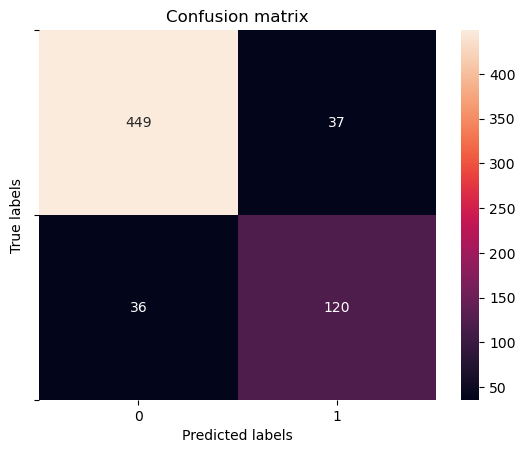

In [50]:
#Classification Report
print(classification_report(y_test, y_predicted))

#Confusion Matrix
cm = confusion_matrix(y_test, y_predicted)
sns.heatmap(cm, annot=True, fmt="d",)

plt.yticks(np.arange(3))
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.title('Confusion matrix')

plt.show()

In [ ]:
#TP = 449, TN = 120 / FP = 36, FN = 37

In [89]:
# As we can see we have worse prediction for class 1, because of imbalance in class

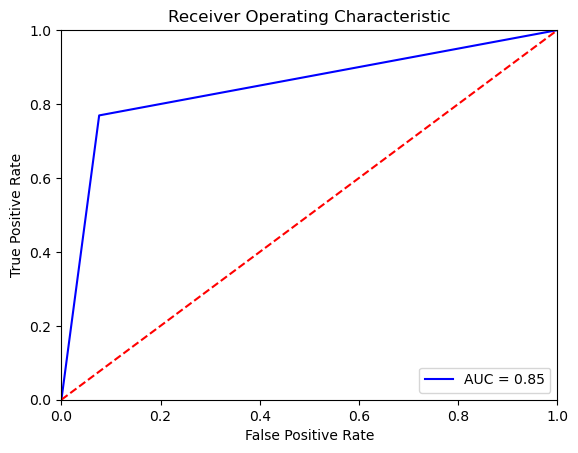

In [51]:
fpr, tpr, threshold = roc_curve(y_test, y_predicted)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Final Conclusion:
This dataset was specific and required a significant amount of domain knowledge to work with effectively. I tried my best to achieve optimal results within the constraints of the assignment and the limited time available. While there is certainly room for improvement, the most important outcome is that the model is not overfitting. With more time and resources, further enhancements could be made to improve its performance.